In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score
# Any results you write to the current directory are saved as output.

# Loading and Preparing Dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class MNIST_Dataset(Dataset):
    
    def __init__(self, X, y, transform = transforms.Compose(
                     [transforms.ToPILImage(), 
                      transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5,), std=(0.5,))])):
            
        self.transform = transform
        self.X = X.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
        self.y = y
        
    @classmethod
    def from_train(cls, file_path_images, file_path_labels):
        train_images = pd.read_pickle(file_path_images)
        train_labels = pd.read_csv(file_path_labels)
        
        return cls(X=train_images, y=torch.from_numpy(train_labels['Category'].values))
        
    @classmethod
    def from_test(cls, file_path_images):
        test_images = pd.read_pickle(file_path_images)
        
        return cls(X=test_images, y=None)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.transform(self.X[idx])
        X = X.to(device)
        if self.y is not None:
            return X, self.y[idx].to(device)
        else:
            return X

In [3]:
train_data = pd.read_pickle('../input/train_images.pkl')
train_labels = pd.read_csv('../input/train_labels.csv')

number_train_images = int(train_data.shape[0] * 0.9)

X_train = train_data[:number_train_images]
y_train = torch.from_numpy(train_labels['Category'][:number_train_images].values)

X_validation = train_data[number_train_images:]
y_validation = train_labels['Category'][number_train_images:].values

In [4]:
batch_size = 64

train_dataset = MNIST_Dataset(X_train, y_train)
validation_dataset = MNIST_Dataset(X_validation, None)
test_dataset = MNIST_Dataset.from_test('../input/test_images.pkl')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

# Neural Network Architecture, and Optimizer, and Loss Functions

In [5]:
class ConvNet_3Layers(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.5):
        super(ConvNet_3Layers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(dropout))
        self.fc = nn.Linear(2048, output_dim)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

class ConvNet_4Layers(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(ConvNet_4Layers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(dropout))
        self.fc = nn.Linear(256, output_dim)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
def predict(model, data_loader):
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

# Training Loop

In [7]:
def train_model(model_class, validation_loader, y_validation, dropout=0.5, epochs=30, criterion=nn.CrossEntropyLoss(), learning_rate=1e-3):
    input_dim = 64 * 64
    output_dim = 10
    model = model_class(input_dim, output_dim, dropout).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses_per_epoch = []
    validation_score_per_epoch = []
    for epoch in range(epochs):
    
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.to(dtype=torch.long)
            optimizer.zero_grad()

            outputs = model(inputs)        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        validation_predictions = predict(model, validation_loader).numpy()
        validation_score_per_epoch.append(accuracy_score(y_validation, validation_predictions))
        model.train()
        
        losses_per_epoch.append(loss)
    print('[Finished Training] Score: %.4f Loss: %.4f' % (validation_score_per_epoch[-1], losses_per_epoch[-1]))
    return model, losses_per_epoch, validation_score_per_epoch

In [8]:
summary_3_layers = {'model' : [], 'loss' : [], 'score' : []}
dropouts = [0.1, 0.25, 0.5]
for dp in dropouts:
    model, loss, score = train_model(ConvNet_3Layers, validation_loader, y_validation, dropout=dp, epochs=20)
    summary_3_layers['model'].append(model)
    summary_3_layers['loss'].append(loss)
    summary_3_layers['score'].append(score)

[Finished Training] Score: 0.9345 Loss: 0.0355
[Finished Training] Score: 0.9367 Loss: 0.1316
[Finished Training] Score: 0.9320 Loss: 0.1793


In [9]:
summary_4_layers = {'model' : [], 'loss' : [], 'score' : []}
dropouts = [0.1, 0.25, 0.5]
for dp in dropouts:
    model, loss, score = train_model(ConvNet_4Layers, validation_loader, y_validation, dropout=dp, epochs=20)
    summary_4_layers['model'].append(model)
    summary_4_layers['loss'].append(loss)
    summary_4_layers['score'].append(score)

[Finished Training] Score: 0.9385 Loss: 0.0055
[Finished Training] Score: 0.9483 Loss: 0.0357
[Finished Training] Score: 0.9490 Loss: 0.4598


# Loss and Validation Metrics for CNNs with 3 and 4 Layers

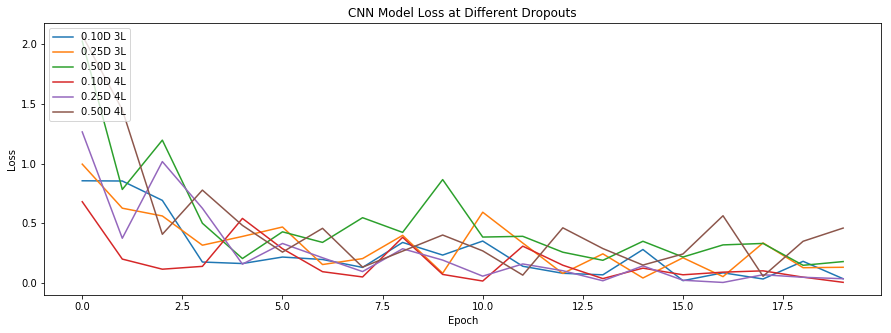

In [10]:
names = ['0.10D 3L', '0.25D 3L', '0.50D 3L', '0.10D 4L', '0.25D 4L', '0.50D 4L']
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(summary_3_layers['loss'][i])
for i in range(3):
    plt.plot(summary_4_layers['loss'][i])
plt.title('CNN Model Loss at Different Dropouts')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
plt.show()

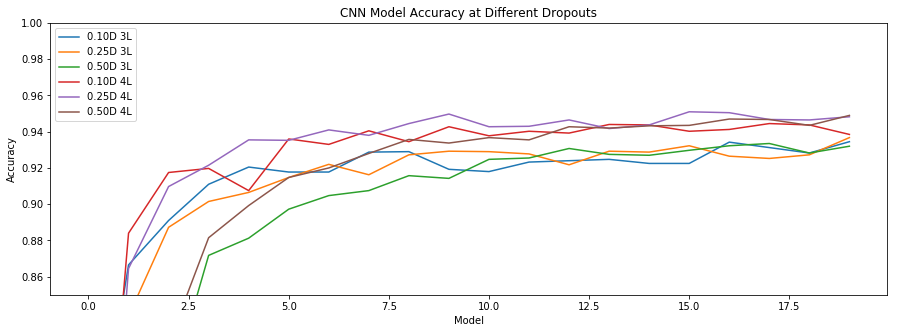

In [11]:
names = ['0.10D 3L', '0.25D 3L', '0.50D 3L', '0.10D 4L', '0.25D 4L', '0.50D 4L']
plt.figure(figsize=(15,5))
for i in range(3):
    plt.plot(summary_3_layers['score'][i])
for i in range(3):
    plt.plot(summary_4_layers['score'][i])
plt.title('CNN Model Accuracy at Different Dropouts')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

# Best Model Training

In [12]:
train_dataset = MNIST_Dataset(train_data, torch.from_numpy(train_labels['Category'].values))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
input_dim = 64 * 64
output_dim = 10
model = ConvNet_4Layers(input_dim, output_dim, dropout=0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion=nn.CrossEntropyLoss()

losses_per_epoch = []
epochs = 250
for epoch in range(epochs):

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.to(dtype=torch.long)
        optimizer.zero_grad()

        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    losses_per_epoch.append(loss)
print('Finished Training')

Finished Training


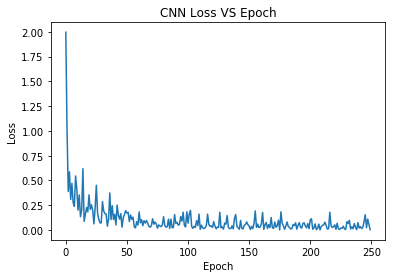

In [13]:
plt.plot(losses_per_epoch)
plt.title('CNN Loss VS Epoch')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.show()

# Prediction on Test Set

In [14]:
test_predictions = predict(model, test_loader)
test_predictions = test_predictions.numpy()

In [15]:
d = {'Id' : [x for x in range(0, len(test_predictions))], 'Category' : test_predictions.flatten().tolist()}
submission = pd.DataFrame(d)
submission.to_csv(path_or_buf='submission.csv', index=False)